# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. The occurrences of terms and structures in each domain is what we refer to as the domain "archetype." Here, we'll assess whether the observed similarity between documents and the archetype is greater than expected by chance. This would indicate that information in the framework generalizes well to individual documents.

# Load the data

In [1]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
import utilities
from ontology import ontology
from style import style

In [2]:
version = 190325 # Document-term matrix version
clf = "lr" # Classifier used to generate the framework
suffix = "_" + clf # Suffix for term lists
n_iter = 1000 # Iterations for null distribution
circuit_counts = range(2, 51) # Range of k values

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Document splits

In [5]:
splits = {}
splits["train"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["validation"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["test"] = [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, split_pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(split_pmids)))

Train        N=12708
Validation   N=3631
Test         N=1816


In [6]:
split = "validation"
pmids = dtm_bin.index.intersection(act_bin.index)
split_pmids = splits[split]

# Index by PMID and sort by structure

In [7]:
structures = sorted(list(set(act_bin.columns)))
act_structs = act_bin.loc[pmids, structures]

# Compute observed values

In [8]:
from collections import OrderedDict
from scipy.spatial.distance import cdist

In [9]:
def load_kval_archetype_data(k):
    
    lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix=suffix)
    domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))
    
    words = sorted(list(set(lists["TOKEN"])))
    dtm_words = dtm_bin.loc[pmids, words]
    docs = dtm_words.copy()
    docs[structures] = act_structs.copy()

    archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
    for dom in domains:
        for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
            archetypes.loc[word, dom] = 1.0
        for struct in circuits.loc[circuits["DOMAIN"] == dom, "STRUCTURE"]:
            archetypes.loc[struct, dom] = 1.0
    archetypes[archetypes > 0.0] = 1.0

    doc2dom_df = pd.read_csv("../partition/data/doc2dom_k{:02d}_{}.csv".format(k, clf), 
                             header=None, index_col=0)
    doc2dom = {int(pmid): str(dom.values[0]) for pmid, dom in doc2dom_df.iterrows()}
    
    dom2docs = {dom: {split: [] for split in ["train", "validation", "test"]} for dom in domains}
    for doc, dom in doc2dom.items():
        for split, split_pmids in splits.items():
            if doc in splits[split]:
                dom2docs[dom][split].append(doc)
                
    return domains, docs, archetypes, dom2docs

In [10]:
means = {split: np.empty((len(circuit_counts),)) for split in splits.keys()}

for k_i, k in enumerate(circuit_counts):

    file_obs = "data/kvals/arche_obs_k{:02d}_{}.csv".format(k, clf)
    if not os.path.isfile(file_obs):
        domains, docs, archetypes, dom2docs = load_kval_archetype_data(k)

        pmid_list, split_list, dom_list, obs_list  = [], [], [], []

        for split, split_pmids in splits.items():
            split_list += [split] * len(split_pmids)

            for dom in domains:
                dom_pmids = dom2docs[dom][split]
                dom_vecs = docs.loc[dom_pmids].values
                dom_arche = archetypes[dom].values.reshape(1, archetypes.shape[0])
                dom_sims = 1.0 - cdist(dom_vecs, dom_arche, metric="dice")

                pmid_list += dom_pmids
                dom_list += [dom] * len(dom_sims)
                obs_list += list(dom_sims[:,0])

        df_obs = pd.DataFrame({"PMID": pmid_list, "SPLIT": split_list, 
                                   "DOMAIN": dom_list, "OBSERVED": obs_list})
        df_obs.to_csv(file_obs, index=None)
    
    else:
        df_obs = pd.read_csv(file_obs)
    
    for split, split_pmids in splits.items():
        dom_means = []
        for dom in set(df_obs["DOMAIN"]):
            dom_vals = df_obs.loc[(df_obs["SPLIT"] == split) & (df_obs["DOMAIN"] == dom), "OBSERVED"]
            dom_means.append(np.nanmean(dom_vals))
        means[split][k_i] = np.nanmean(dom_means)

/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


## Null distributions

In [11]:
nulls = {split: np.empty((len(circuit_counts),n_iter)) for split in splits.keys()}

for split, split_pmids in splits.items():
    print("Processing {} split".format(split))
    
    for k_i, k in enumerate(circuit_counts):

        file_null = "data/kvals/arche_null_k{:02d}_{}_{}iter.csv".format(k, split, n_iter)
        if not os.path.isfile(file_null):

            print("----- Processing k={:02d}".format(k))

            domains, docs, archetypes, dom2docs = load_kval_archetype_data(k)

            df_null = np.zeros((len(domains), n_iter))
            for n in range(n_iter):
                null = np.random.choice(range(len(docs.columns)), 
                                        size=len(docs.columns), replace=False)
                for i, dom in enumerate(domains):
                    dom_pmids = dom2docs[dom][split]
                    dom_vecs = docs.loc[dom_pmids].values
                    dom_arche = archetypes.values[null,i].reshape(1, archetypes.shape[0])
                    df_null[i,n] = 1.0 - np.mean(cdist(dom_vecs, dom_arche, metric="dice"))

            df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
            df_null.to_csv(file_null)

        else:
            df_null = pd.read_csv(file_null, index_col=0, header=0)

        nulls[split][k_i,:] = np.mean(df_null, axis=0)

Processing train split
Processing validation split
Processing test split


# Bootstrap distributions

In [12]:
boots = {split: np.empty((len(circuit_counts),n_iter)) for split in splits.keys()}

for split, split_pmids in splits.items():
    print("Processing {} split".format(split))
    
    for k_i, k in enumerate(circuit_counts):

        file_boot = "data/kvals/arche_boot_k{:02d}_{}_{}iter.csv".format(k, split, n_iter)
        if not os.path.isfile(file_boot):

            print("----- Processing k={:02d}".format(k))

            domains, docs, archetypes, dom2docs = load_kval_archetype_data(k)

            df_boot = np.zeros((len(domains), n_iter))
            for n in range(n_iter):
                for i, dom in enumerate(domains):

                    dom_pmids = dom2docs[dom][split]
                    boot = np.random.choice(dom_pmids, size=len(dom_pmids), replace=True)

                    dom_vecs = docs.loc[boot]
                    dom_arche = archetypes.values[:,i].reshape(1, archetypes.shape[0])
                    df_boot[i,n] = 1.0 - np.nanmean(cdist(dom_vecs, dom_arche, metric="dice"))

            df_boot = pd.DataFrame(df_boot, index=domains, columns=range(n_iter))
            df_boot.to_csv(file_boot)

        else:
            df_boot = pd.read_csv(file_boot, index_col=0, header=0)

        boots[split][k_i,:] = np.nanmean(df_boot, axis=0)
    print("")

Processing train split
----- Processing k=02
----- Processing k=03
----- Processing k=04
----- Processing k=05
----- Processing k=06
----- Processing k=07
----- Processing k=08
----- Processing k=09
----- Processing k=10
----- Processing k=11
----- Processing k=12
----- Processing k=13
----- Processing k=14
----- Processing k=15
----- Processing k=16
----- Processing k=17
----- Processing k=18
----- Processing k=19
----- Processing k=20
----- Processing k=21
----- Processing k=22
----- Processing k=23
----- Processing k=24
----- Processing k=25
----- Processing k=26
----- Processing k=27
----- Processing k=28
----- Processing k=29
----- Processing k=30
----- Processing k=31
----- Processing k=32
----- Processing k=33
----- Processing k=34
----- Processing k=35
----- Processing k=36
----- Processing k=37
----- Processing k=38
----- Processing k=39
----- Processing k=40
----- Processing k=41
----- Processing k=42
----- Processing k=43
----- Processing k=44
----- Processing k=45
----- Pro

/anaconda3/envs/ontol/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


----- Processing k=37
----- Processing k=38
----- Processing k=39
----- Processing k=40
----- Processing k=41
----- Processing k=42
----- Processing k=43
----- Processing k=44
----- Processing k=45
----- Processing k=46
----- Processing k=47
----- Processing k=48
----- Processing k=49
----- Processing k=50

Processing test split
----- Processing k=02
----- Processing k=03
----- Processing k=04
----- Processing k=05
----- Processing k=06
----- Processing k=07
----- Processing k=08
----- Processing k=09
----- Processing k=10
----- Processing k=11
----- Processing k=12
----- Processing k=13
----- Processing k=14
----- Processing k=15
----- Processing k=16
----- Processing k=17
----- Processing k=18
----- Processing k=19
----- Processing k=20
----- Processing k=21
----- Processing k=22
----- Processing k=23
----- Processing k=24
----- Processing k=25
----- Processing k=26
----- Processing k=27
----- Processing k=28
----- Processing k=29
----- Processing k=30
----- Processing k=31
----- Pro

### Plot results over k

In [13]:
from matplotlib import rcParams
%matplotlib inline

In [14]:
rcParams["axes.linewidth"] = 1.5

TRAIN


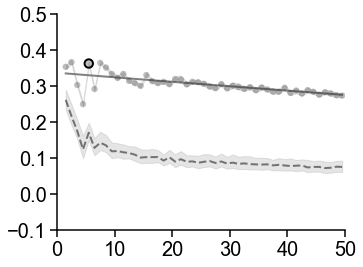

VALIDATION


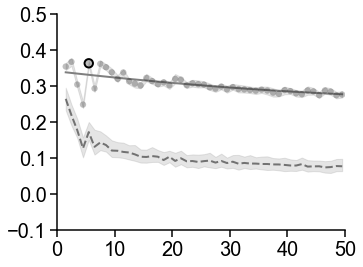

TEST


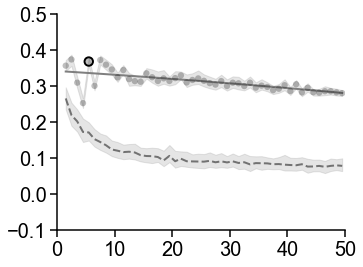

In [15]:
for split in splits.keys():
    print(split.upper())
    utilities.plot_stats_by_k(means, nulls, boots, circuit_counts, metric="arche",
                              split=split, op_k=6, clf=clf, interval=0.999, ylim=[-0.1,0.5], 
                              yticks=[-0.1,0,0.1,0.2,0.3,0.4,0.5])